In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
# See https://duetosymmetry.com/code/latex-mpl-fig-tips/
plt.style.use("mda.mplstyle")

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.

jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
            "CQG": {"onecol": 374.*pt}, # CQG is only one column
            # Add more journals below. Can add more properties to each journal
    }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

## RMSD of Zebrafish Hb only

In [4]:
from MDAnalysis.analysis import rms
#Read all the trajectories
protein_prod = mda.Universe('zeb_hb_only_sim/sys_prod/prod_zeb_hb_only.gro', 'zeb_hb_only_sim/sys_prod/prod_zeb_hb_only_compact_compact.xtc')

R = rms.RMSD(protein_prod,  # universe to align
    protein_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run()
times_p = R.results.rmsd[:,1]
rmsd_p = R.results.rmsd[:,2]

## Radius of Gyration of Zebrafish Hb only

In [3]:
from tqdm import tqdm
group = protein_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(protein_prod.trajectory):
	Frame.append(ts.frame)
	times.append(protein_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrp_table = np.vstack((Frame, times, Rgyr)).T

## RMSD of Zebrafish Hb and PHZ Complex

In [5]:
from MDAnalysis.analysis import rms
#Read all the trajectories
complex_prod = mda.Universe('zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.gro', 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc')

R = rms.RMSD(complex_prod,  # universe to align
    complex_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run()
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]

## Radius of Gyration of Zebrafish Hb and PHZ Complex

In [6]:
from tqdm import tqdm
group = complex_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(complex_prod.trajectory):
	Frame.append(ts.frame)
	times.append(complex_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 10001/10001 [00:35<00:00, 279.69it/s]


## Plot everything

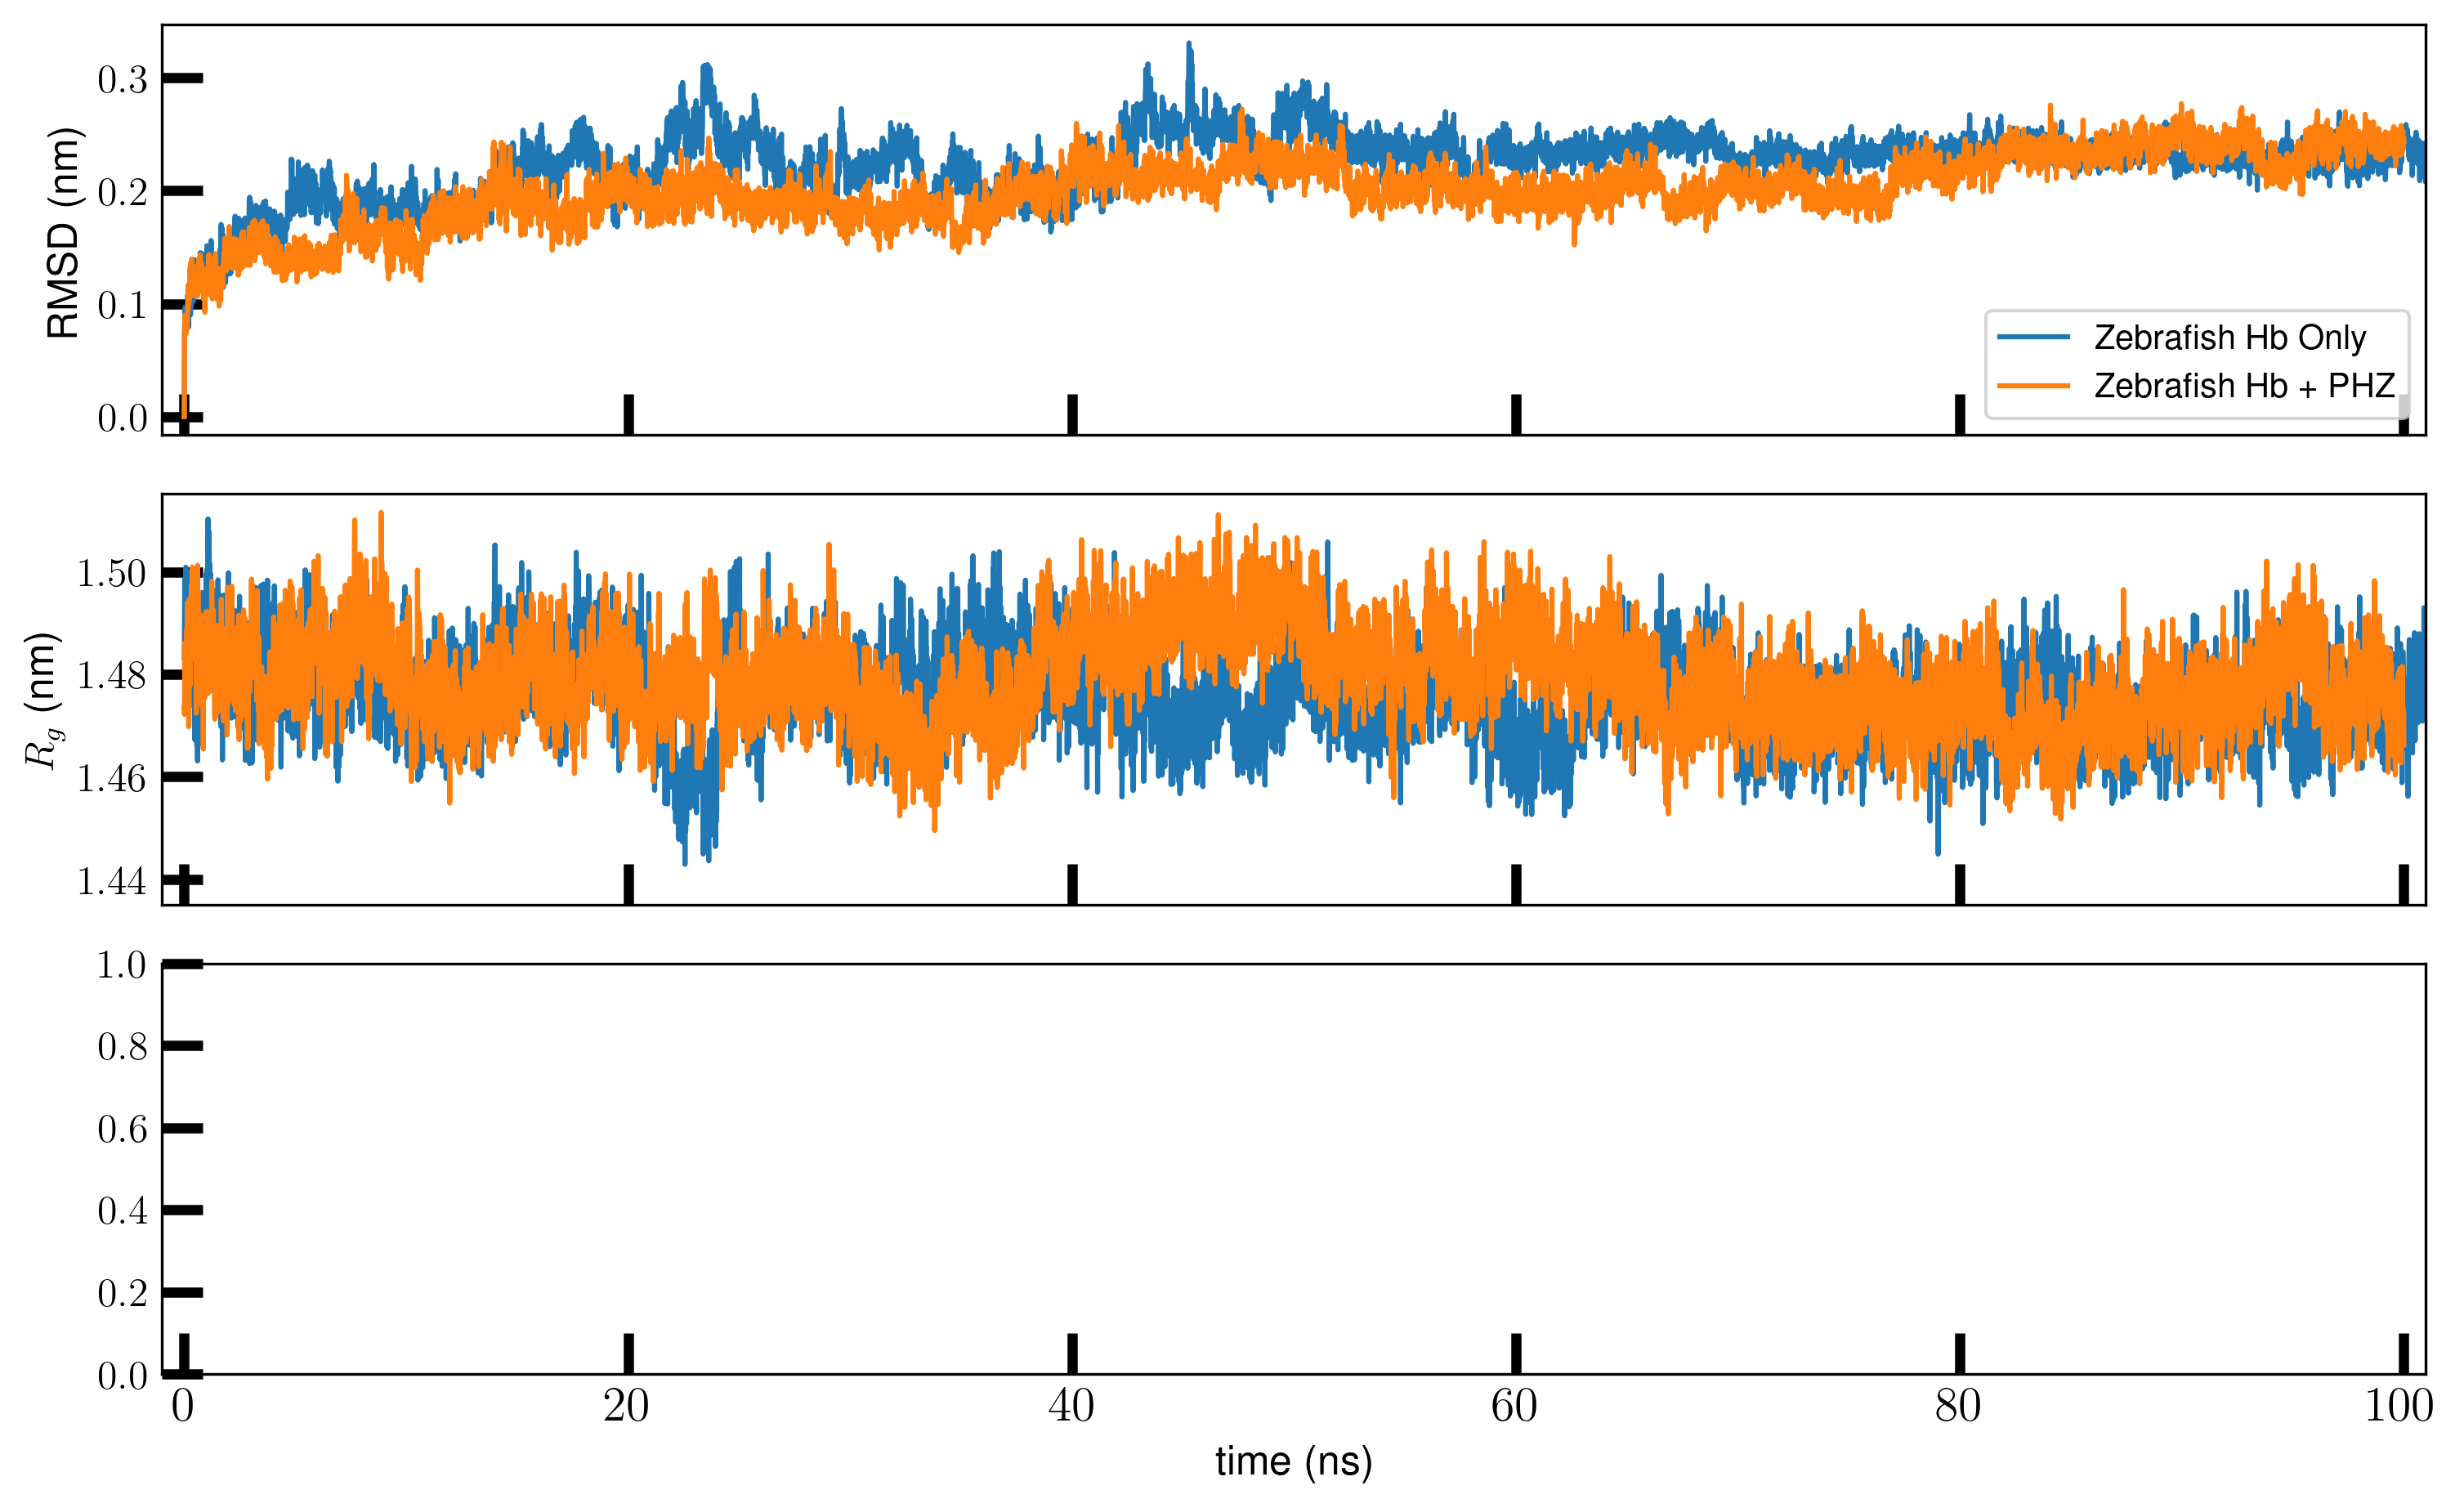

In [7]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True, figsize = (npanels * my_width, npanels*my_width/golden))

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(times_p/1000, rmsd_p/10, label="Zebrafish Hb Only")
ax_rmsd.plot(times_c/1000, rmsd_c/10, label="Zebrafish Hb + PHZ")

ax_rmsd.legend()

ax_rg = axs[1]
ax_rg.plot(Rgyrp_table[:,1]/1000, Rgyrp_table[:,2]/10, label="Zebrafish Hb Only")
ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, label="Zebrafish Hb + PHZ")
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');
ax_bonds.set_xlim(-1, 101);

## RMSF: Protein backbone and Carbon alpha

In [73]:
c_alphas_p = protein_prod.select_atoms('backbone and name CA')
# I ran the protein for twice the time of the complex, so have to cut the protein data
R_p_half = rms.RMSF(c_alphas_p).run(start=0, stop=len(times_c)//2)

c_alphas_c = complex_prod.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run()


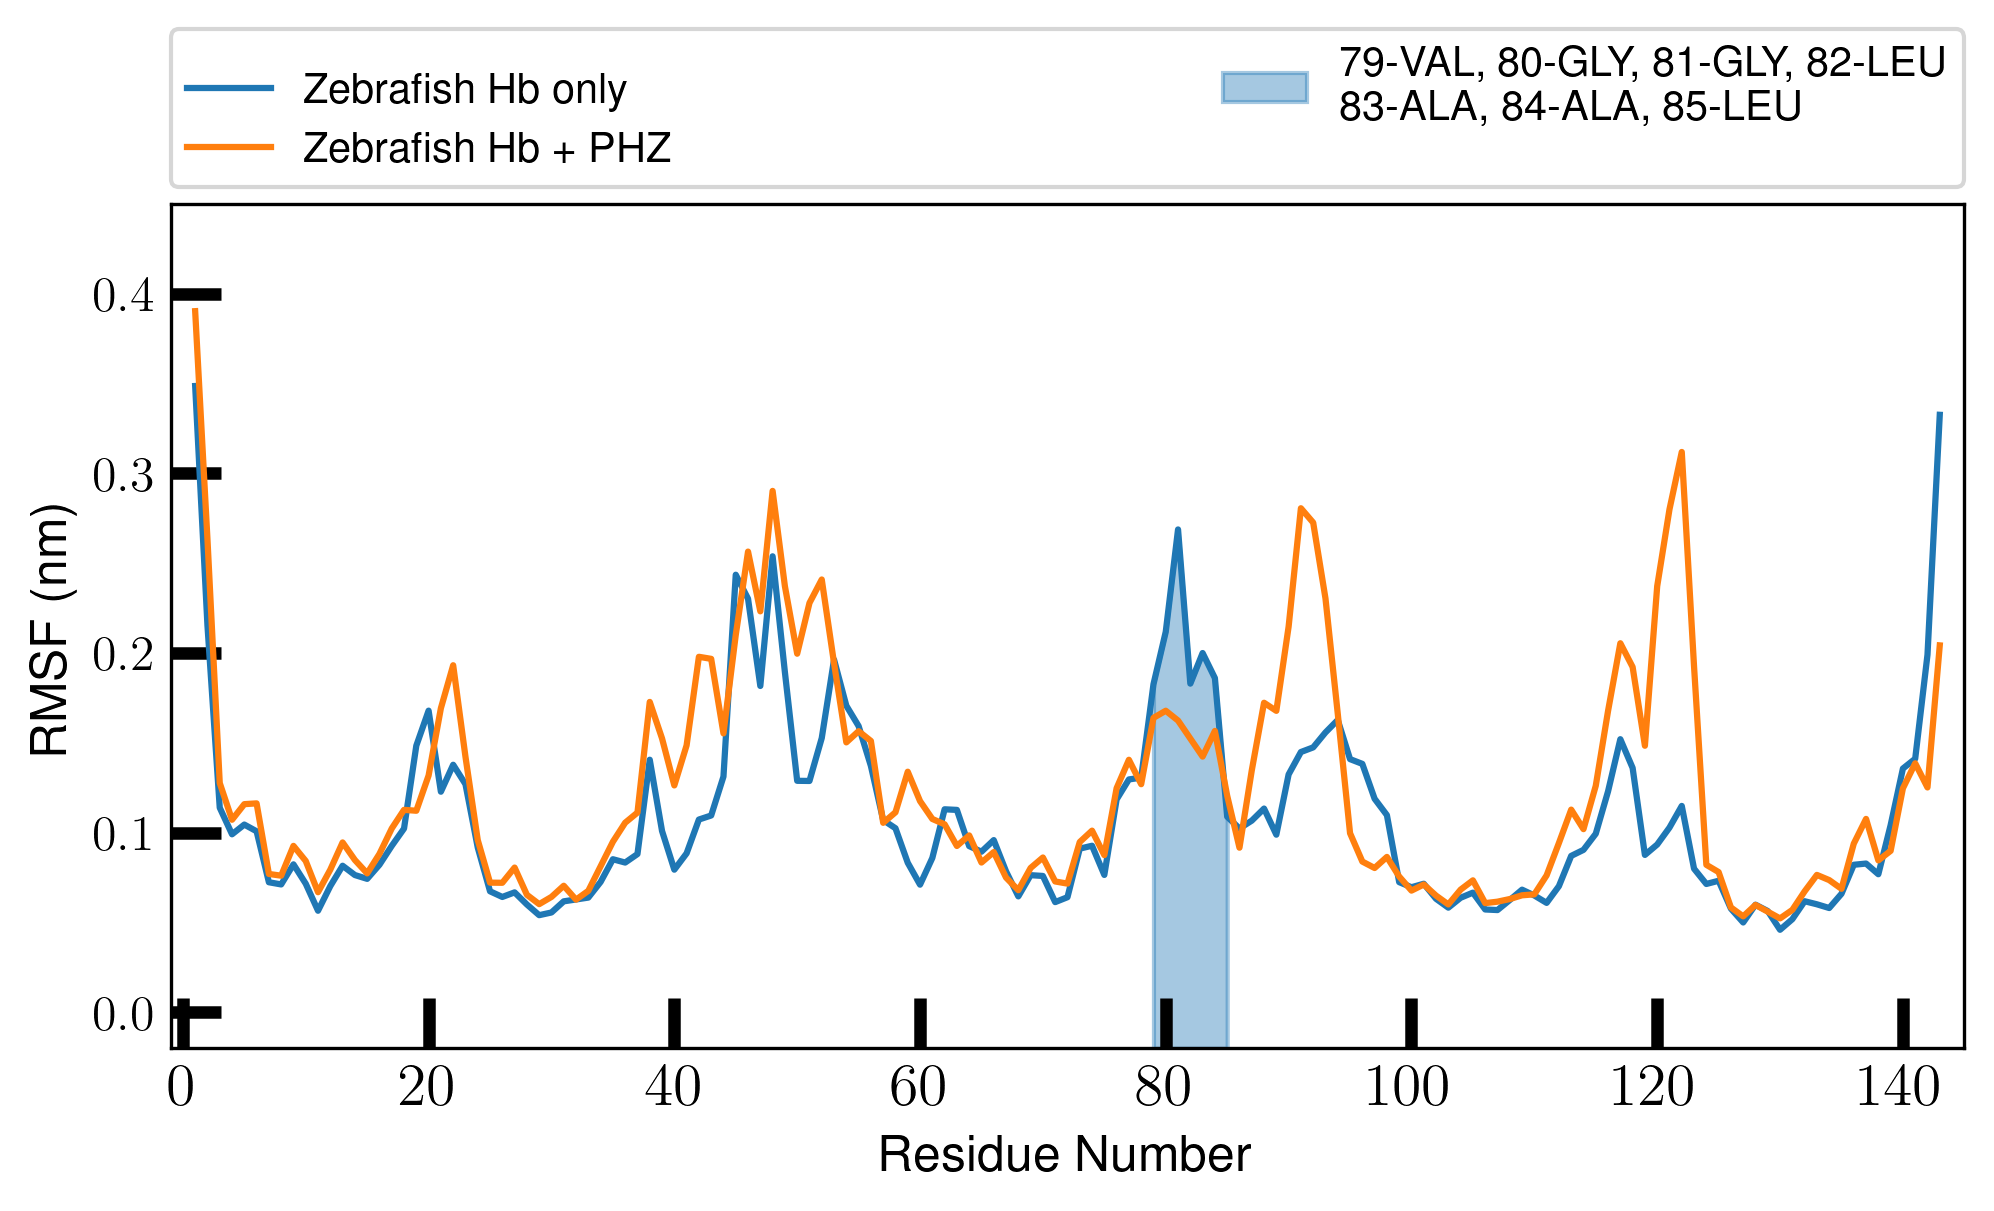

In [116]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (2*my_width, 2*my_width/golden))
line_p, = plt.plot(c_alphas_p.resids, R_p.results.rmsf/10, label="Zebrafish Hb only")
line_c, = plt.plot(c_alphas_c.resids, R_c.results.rmsf/10, label="Zebrafish Hb + PHZ")

resids = np.array([79, 80, 81, 82, 83, 84, 85])
resnames = ''
for resid in resids:
    residues = protein_prod.select_atoms(f'resid {resid}')
    resnames += f'{resid}-{residues.resnames[0]}'
    if resid == 82:
        resnames += '\n'
    else:
        resnames += ', ' if resid != resids[-1] else '' 
    
plt.fill_between(resids, -0.02, R_p.results.rmsf[resids-1]/10, alpha=0.4, label=resnames,color=line_p.get_color())


plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')
plt.xlim(-1, 145)
plt.ylim(-0.02, 0.45)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.)
plt.tight_layout()

In [12]:
mda.__version__

'2.7.0'

## H-bond analysis: TODO

Note: as of today (20240929), the latest stable version of `mdanalysis-2.7.0` cannot import `GROMACS` tpr files from `gromacs-2024.2`, yielding this exception

```python
ValueError: Failed to construct topology from file zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr with parser <class 'MDAnalysis.topology.TPRParser.TPRParser'>.
Error: Your tpx version is 133, which this parser does not support, yet
```

So we have to install the development version from GitHub. 

### Instructions:

```bash
$ conda create -n mdanalysis-develop numpy cython
$ conda activate mdanalysis-develop
$ git clone --depth=50 https://github.com/MDAnalysis/mdanalysis.git
$ cd mdanalysis
$ git branch

* develop

$ pip install package/
$ pip install testsuite/ #Optional
$ python -c 'import MDAnalysis as mda; print(mda.__version__)'
2.8.0-dev0
```
Then, reload jupyter kernel in this new environment.

In [ ]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

#Giving full tpr file to include bonding info
u = mda.Universe("zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr", "zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc")

hbonds = HBA(universe=u)

phz_hydrogens_sel = hbonds.guess_hydrogens("resname PHZ")
protein_acceptors_sel = hbonds.guess_acceptors("protein")

hbonds.run()